In [18]:
import pandas as pd
import numpy as np
from darts import TimeSeries
import config
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from darts.metrics import mase,ope,r2_score,mape
from darts.models import RNNModel, TCNModel, TransformerModel, NBEATSModel, BlockRNNModel, TFTModel, NaiveSeasonal, NaiveDrift, ExponentialSmoothing, TBATS, AutoARIMA, Theta

In [19]:
data_filename = 'count_dict_hinjewadi.pickle'

In [20]:
count_dict = pd.read_pickle(config.DATA+'//data//'+data_filename)

In [21]:
df_item = pd.concat([count_dict['Poha']])

In [22]:
df_item = df_item.resample('D', on = 'Order Placed Date_Time').sum()

In [23]:
df_item['Total Count'].describe()

count    169.000000
mean      67.538462
std       52.943029
min        0.000000
25%       16.000000
50%       66.000000
75%      108.000000
max      250.000000
Name: Total Count, dtype: float64

In [24]:
# Create a TimeSeries, specifying the time and value columns
series = TimeSeries.from_dataframe(df_item,freq='D',fill_missing_dates=True)
series2 = series.add_holidays('IN','KA')


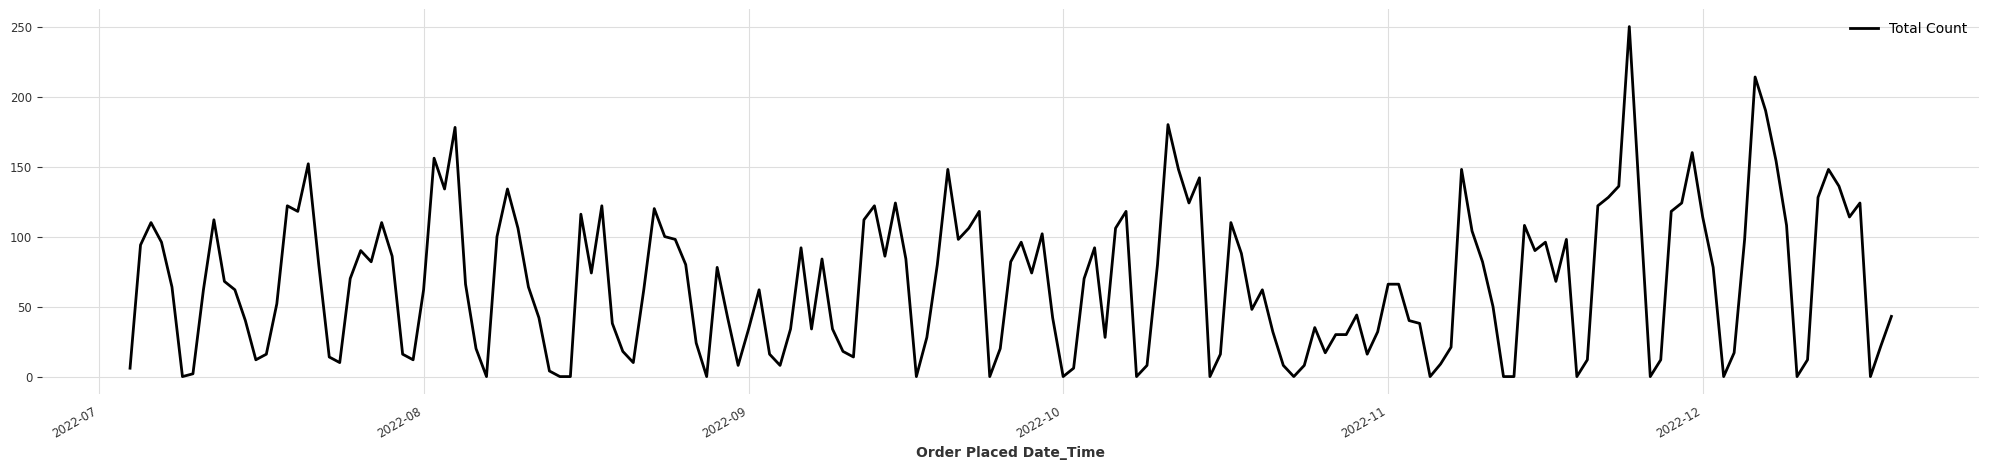

In [25]:
fig = plt.figure(figsize=(25,5))
series.plot()


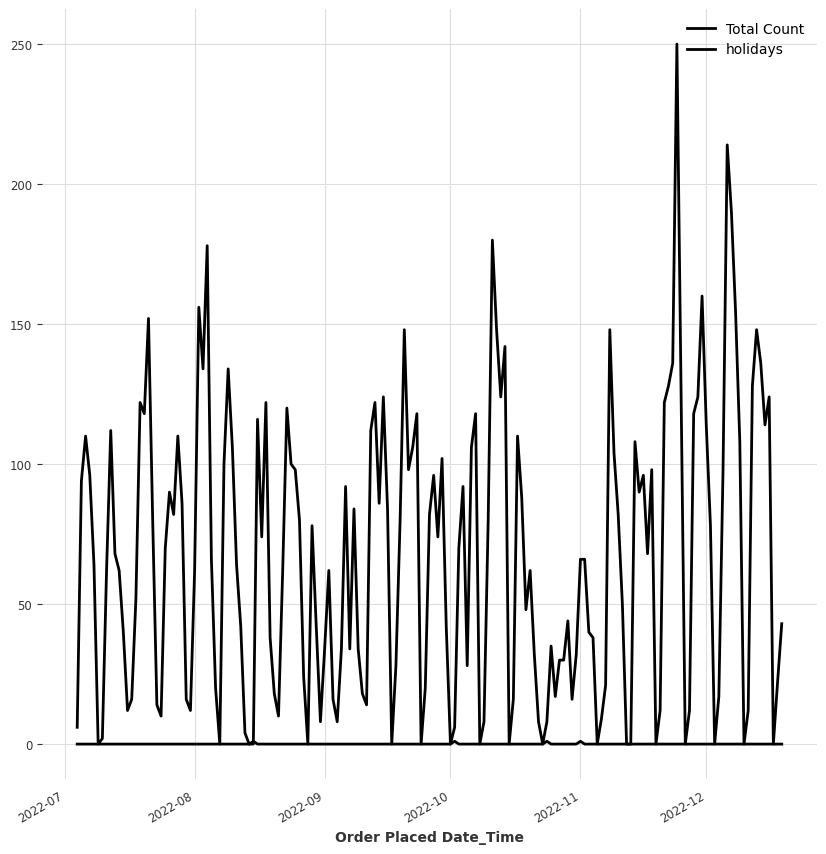

In [26]:
fig = plt.figure(figsize=(10,10))   
ax = fig.add_subplot()
series2.plot(linestyle = '-', color = 'black')


In [27]:
train, val = series.split_before(0.75)

Text(0, 0.5, 'Item Count')

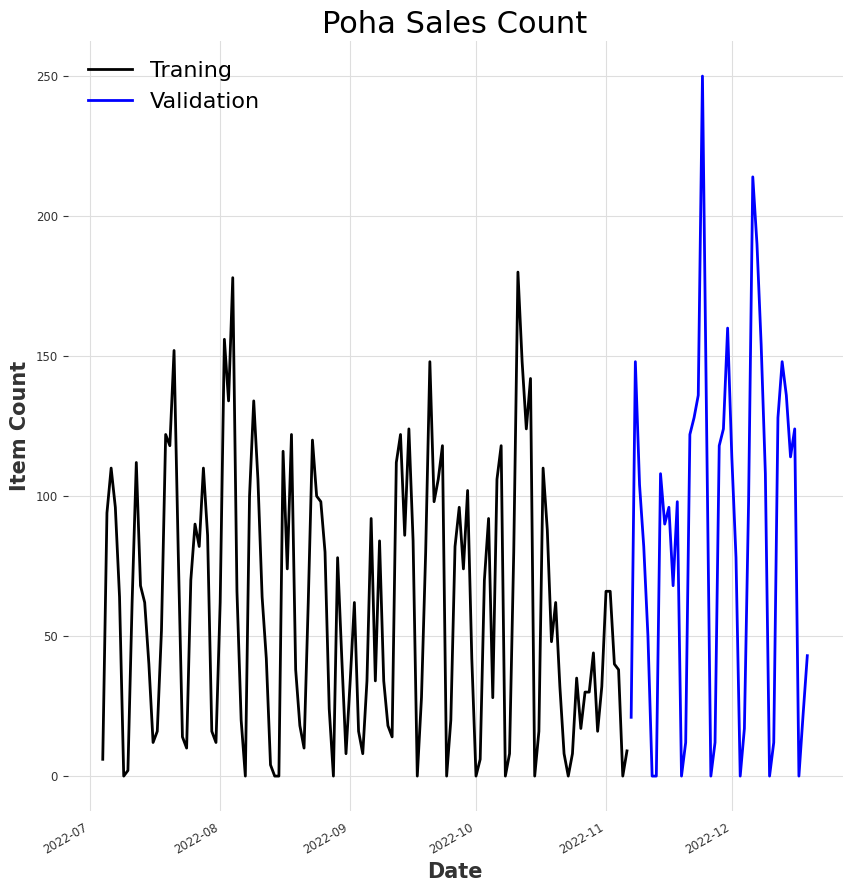

In [28]:
fig = plt.figure(figsize=(10,10))   
train.plot(linestyle = '-', color = 'black')
val.plot(linestyle = '-', color = 'blue')
plt.title('Poha Sales Count',fontsize = 22)
plt.legend(loc=0, prop={'size': 16},labels= ['Traning','Validation','Holiday_train','Holiday_val'])
plt.xlabel('Date',fontsize = 15)
plt.ylabel('Item Count',fontsize = 15)

## Naive Baseline Model

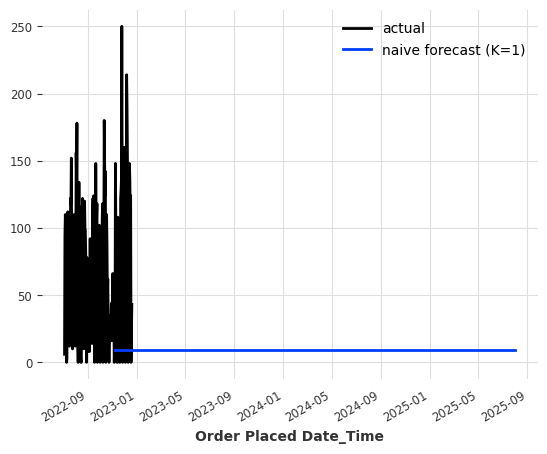

In [29]:
naive_model = NaiveSeasonal(K=1)
naive_model.fit(train)
naive_forecast = naive_model.predict(1000)

series.plot(label="actual")
naive_forecast.plot(label="naive forecast (K=1)")

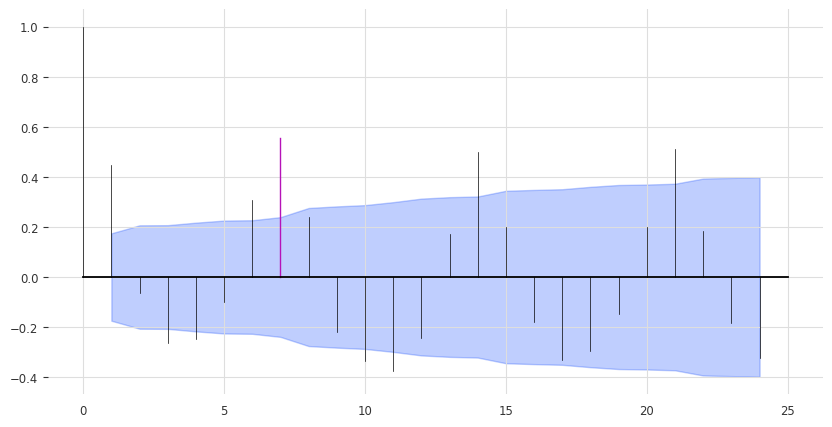

In [30]:
from darts.utils.statistics import plot_acf, check_seasonality

plot_acf(train, m=7, alpha=0.05)

In [31]:
for m in range(2, 12):
    is_seasonal, period = check_seasonality(train, m=m, alpha=0.05)
    if is_seasonal:
        print("There is seasonality of order {}.".format(period))

There is seasonality of order 7.


Text(0, 0.5, 'Item Count')

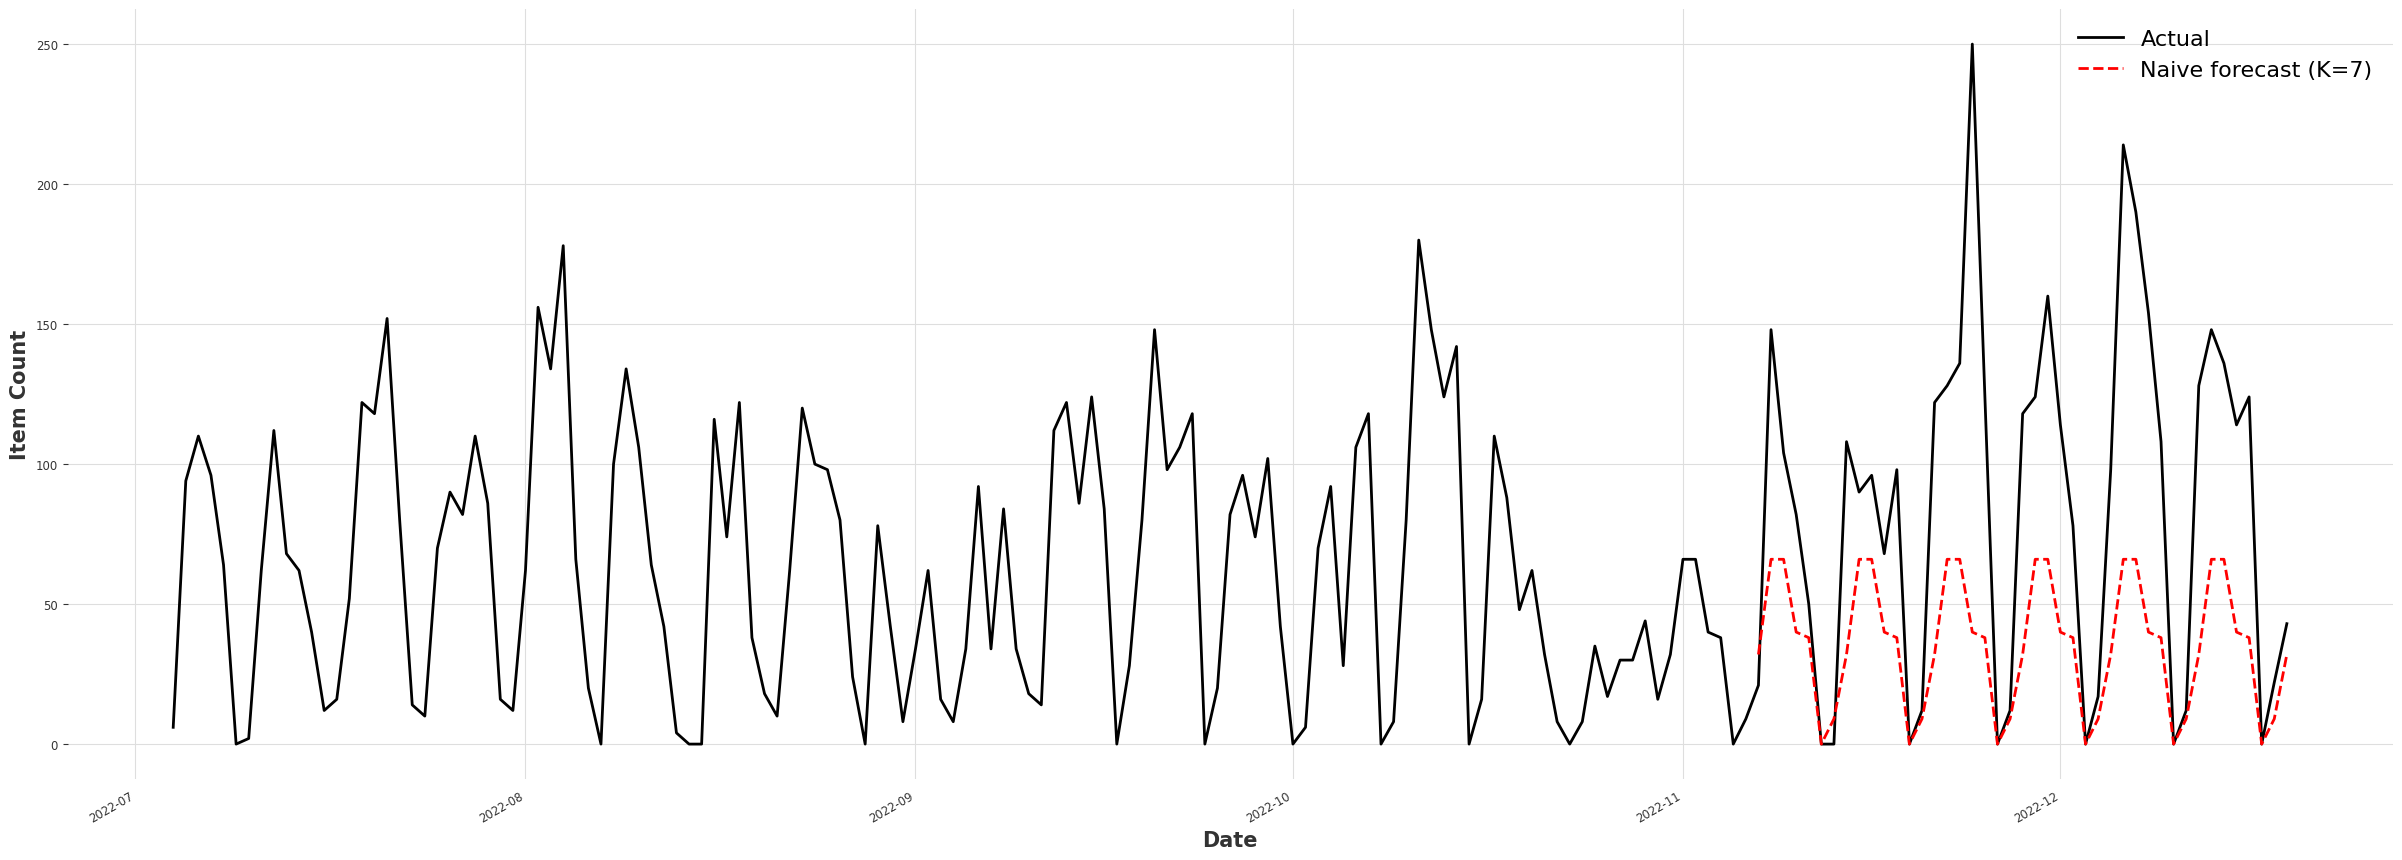

In [32]:
naive_model = NaiveSeasonal(K=7)
naive_model.fit(train)
naive_forecast = naive_model.predict(len(val))

fig = plt.figure(figsize=(30,10))   
series.plot(label="actual",linestyle = '-', color = 'black')
naive_forecast.plot(label="naive forecast (K=7)",linestyle = '--', color = 'red')
plt.legend(loc=0, prop={'size': 16},labels= ['Actual','Naive forecast (K=7)'])
plt.xlabel('Date',fontsize = 15)
plt.ylabel('Item Count',fontsize = 15)


In [33]:
print("naive model {} MASE: {:.2f}".format(naive_model, mase(val, naive_forecast, train)))

naive model Naive seasonal model, with K=7 MASE: 1.37


Text(0, 0.5, 'Item Count')

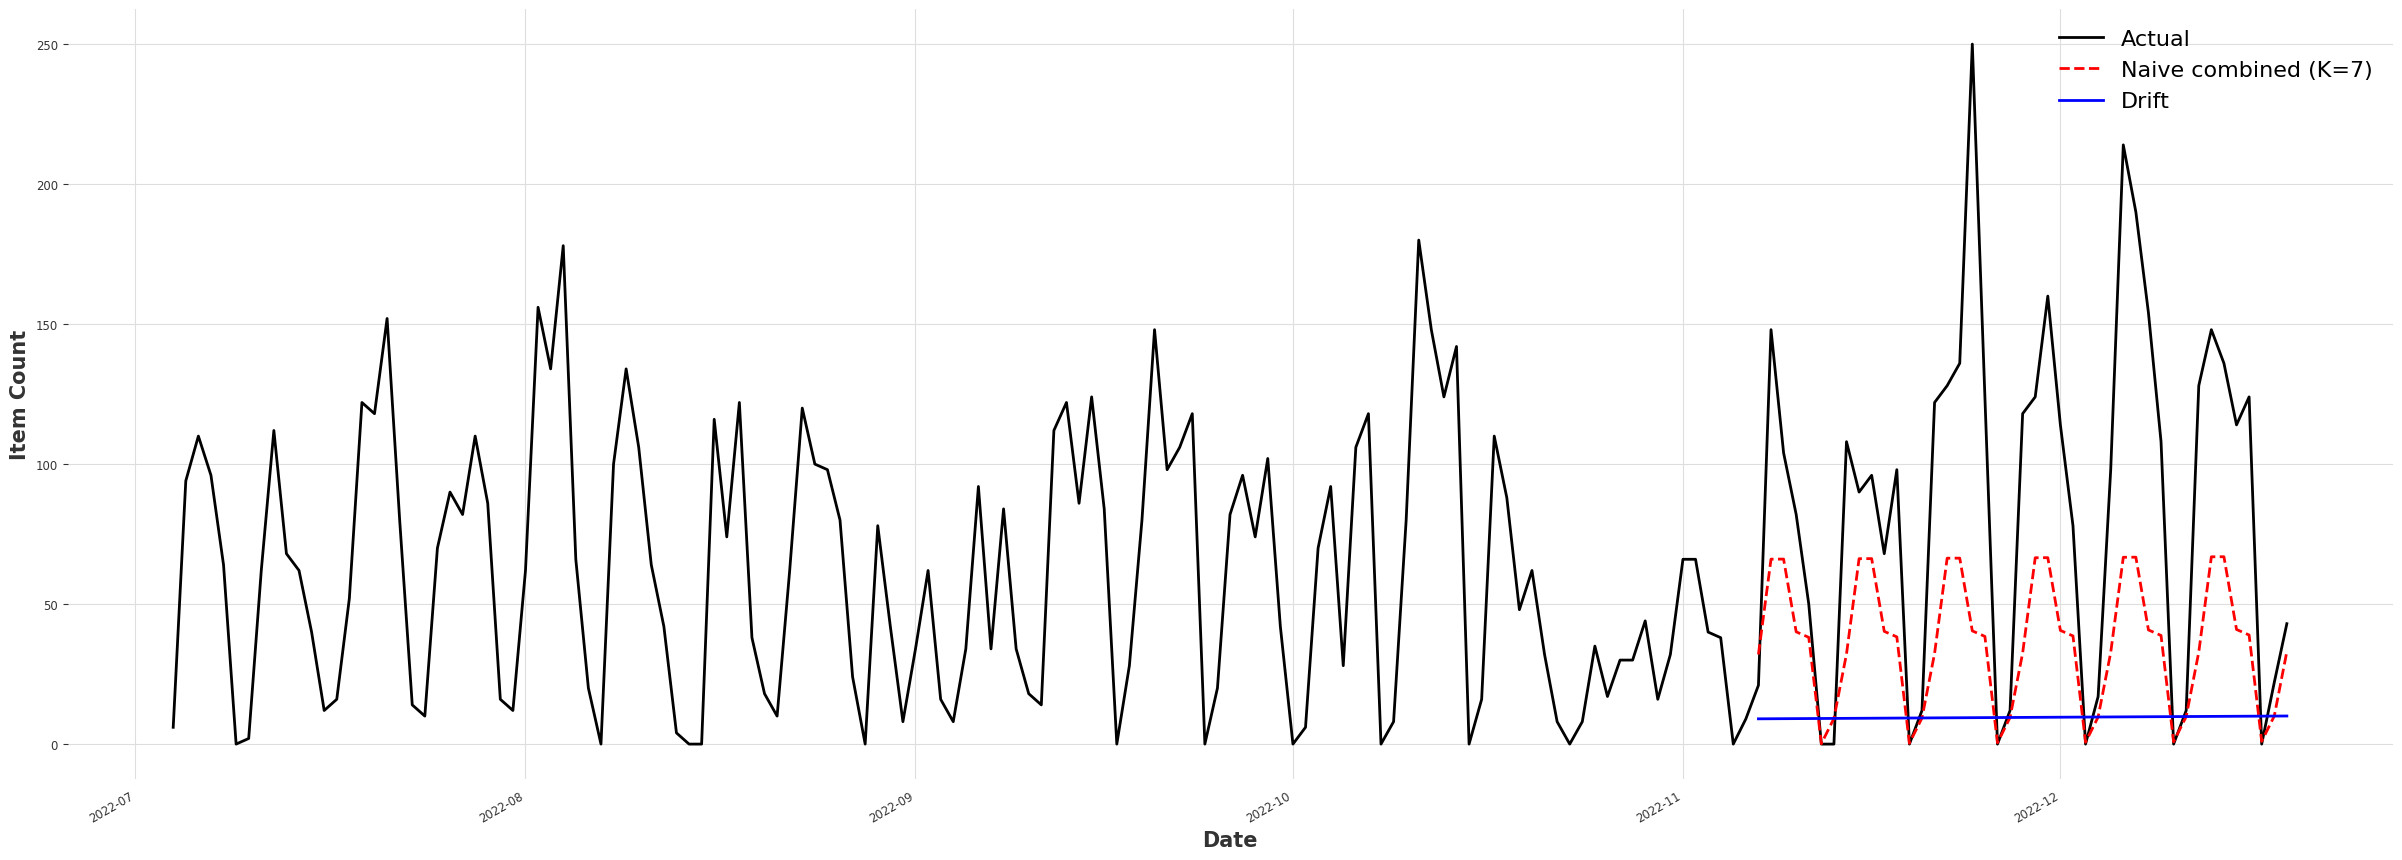

In [34]:
from darts.models import NaiveDrift

naive_drift_model = NaiveDrift()
naive_drift_model.fit(train)
naive_drift_forecast = naive_drift_model.predict(len(val))

naive_combined_forecast = naive_drift_forecast + naive_forecast - train.last_value()



# fig = plt.figure(figsize=(30,10))  
# series.plot()
# naive_combined_forecast.plot(label="combined")
# naive_drift_forecast.plot(label="drift")

fig = plt.figure(figsize=(30,10))   
series.plot(label="actual",linestyle = '-', color = 'black')
naive_combined_forecast.plot(label="naive combined forecast (K=7)",linestyle = '--', color = 'red')
naive_drift_forecast.plot(label="drift",linestyle = '-', color = 'blue')
plt.legend(loc=0, prop={'size': 16},labels= ['Actual','Naive combined (K=7)', 'Drift'])
plt.xlabel('Date',fontsize = 15)
plt.ylabel('Item Count',fontsize = 15)

In [35]:
print("naive model {} MASE: {:.2f}".format(naive_drift_model, mase(val, naive_combined_forecast,train)))

naive model Naive drift model MASE: 1.36


In [38]:
def eval_model(model,series,train, val):
    model.fit(train)
    forecast = model.predict(len(val))
    #print("model {} MAPE: {:.2f}%".format(model, mape(val, forecast)))
    print("model {} MASE: {:.2f}.".format(model,mase(val,forecast,train)))
    #print("model {} OPE: {:.2f}.".format(model,ope(val, forecast)))
    print("model {} R2: {:.2f}.".format(model,r2_score(val, forecast)))

    fig, ax = plt.subplots(2,figsize=(15, 7.5))
    cycler = plt.cycler(linestyle=['-', '--',], color=['black', 'red'])
    #ax = fig.add_subplot()
    ax[0].set_prop_cycle(cycler)
    ax[1].set_prop_cycle(cycler)

    for label in (ax[0].get_xticklabels() + ax[0].get_yticklabels()):
        label.set_fontsize(18)

    #plt.figure(figsize=(30, 5))
    series.plot(label="Actual", ax = ax[0])
    #val.plot(label="Validation", ax = ax[0])
    forecast.plot(label="Forecast", ax=ax[0])
    ax[0].legend(loc='upper right')
    #plt.show()

    for label in (ax[1].get_xticklabels() + ax[1].get_yticklabels()):
        label.set_fontsize(18)

    #plt.figure(figsize=(30, 5))
    val.plot(label="Validation", ax = ax[1])
    forecast.plot(label="Forecast", ax=ax[1])
    ax[1].legend(loc='upper right')
    ax[1].set_xlim(val.pd_dataframe().index[0], val.pd_dataframe().index[-1])
    #ax[1].set_ylim(0, 0.4)
    #plt.show()


    return model, forecast



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


model ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7 MASE: 1.11.
model ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7 R2: 0.20.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


model (T)BATS MASE: 1.00.
model (T)BATS R2: 0.34.


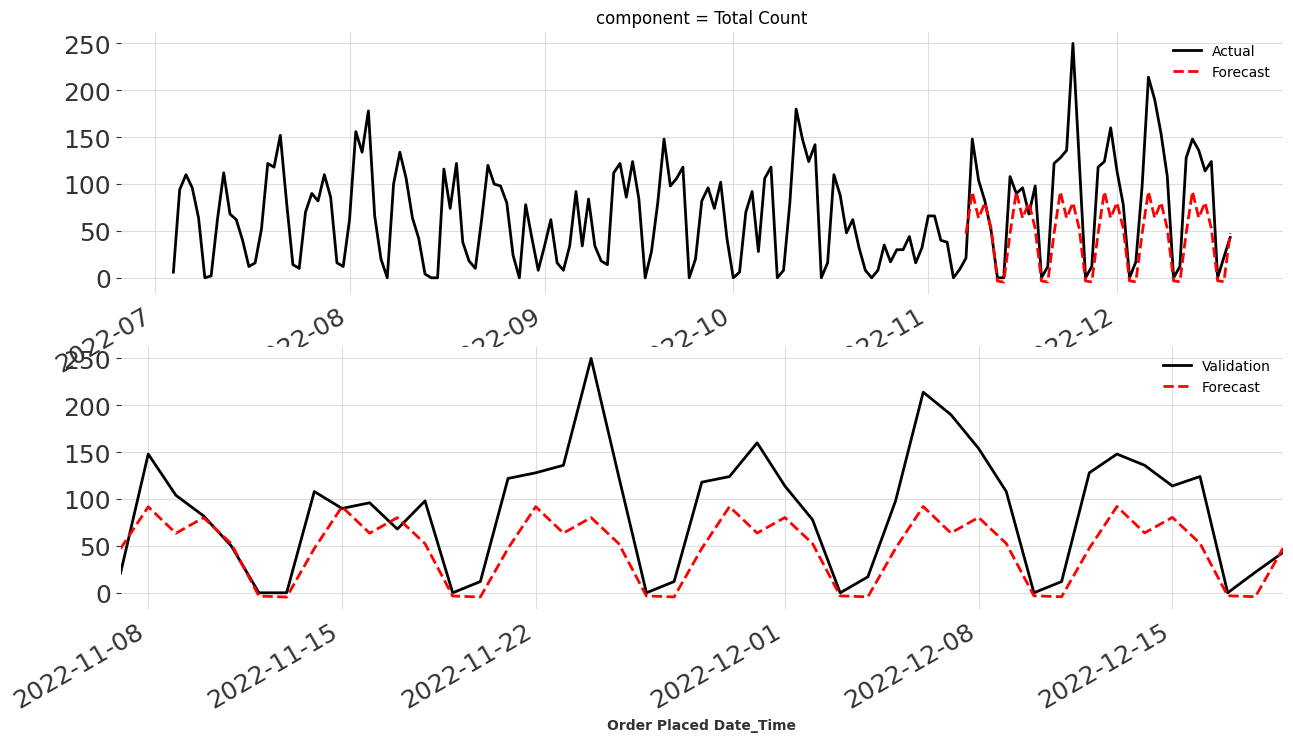

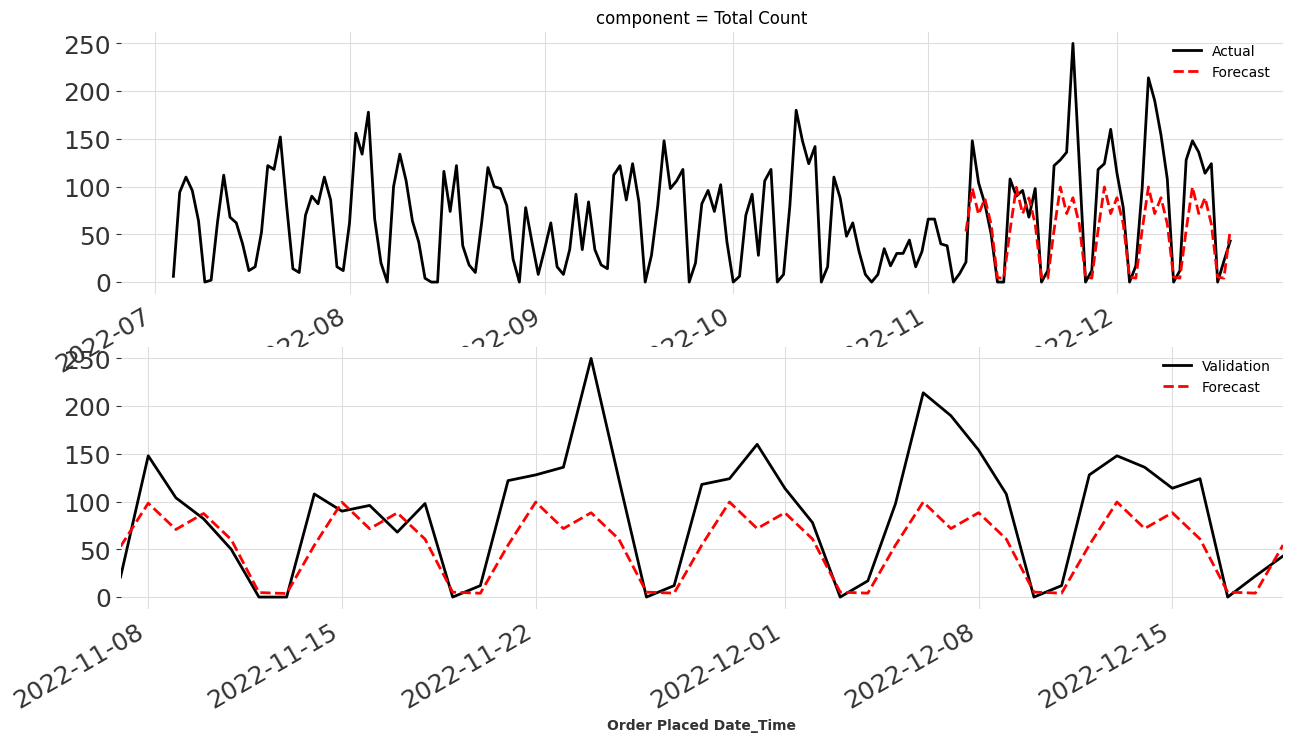

In [39]:
ES, forecast = eval_model(ExponentialSmoothing(),series,train,val)
TBATS, forecast = eval_model(TBATS(),series,train,val)
#AR, forecast = eval_model(AutoARIMA(),series,train,val)
#TH, forecast = eval_model(Theta(),series,train,val)

In [ ]:
# # Search for the best theta parameter, by trying 50 different values
# thetas = 2 - np.linspace(-10, 10, 100)

# best_mape = float("inf")
# best_theta = 0

# for theta in thetas:
#     model = Theta(theta)
#     model.fit(train)
#     pred_theta = model.predict(len(val))
#     res = mape(val, pred_theta)

#     if res < best_mape:
#         best_mape = res
#         best_theta = theta

In [ ]:
# best_theta_model = Theta(best_theta)
# best_theta_model.fit(train)
# pred_best_theta = best_theta_model.predict(len(val))

# print(
#     "The MAPE is: {:.2f}, with theta = {}.".format(
#         mape(val, pred_best_theta), best_theta
#     )
# )

In [ ]:
# historical_fcast = ES.historical_forecasts(
#     series, start=0.6, forecast_horizon=2000, verbose=True
# )

# series.plot(label="data")
# historical_fcast.plot(label="backtest 3-months ahead forecast (Theta)")
# print("MASE = {:.2f}%".format(mase(historical_fcast, series)))

In [ ]:
# from darts.dataprocessing.transformers import Scaler
# scaler = Scaler()F
# series_scaled = scaler.fit_transform(series)

In [41]:
series_scaled = series

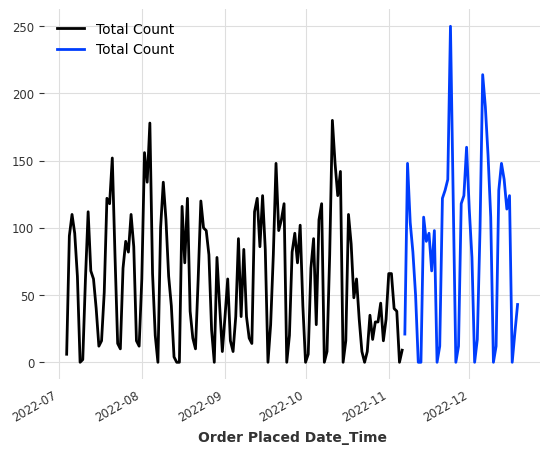

In [42]:
train, val = series_scaled.split_before(0.75)
train.plot()
val.plot()

In [ ]:
# prediction.pd_dataframe()['Total Count'].sort_values(ascending=True)
# prediction = prediction.pd_dataframe()
# prediction[prediction['Total Count'] <= 0] = 0
# prediction = prediction.round(2)
# prediction = TimeSeries.from_dataframe(prediction)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 6.2 M 
---------------------------------------------------
6.2 M     Trainable params
1.5 K     Non-trainable params
6.2 M     Total params
49.819    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


Predicting: 3it [00:00, ?it/s]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


model <darts.models.forecasting.nbeats.NBEATSModel object at 0x0000023E4EE82B20> MASE: 1.70.
model <darts.models.forecasting.nbeats.NBEATSModel object at 0x0000023E4EE82B20> R2: -0.67.


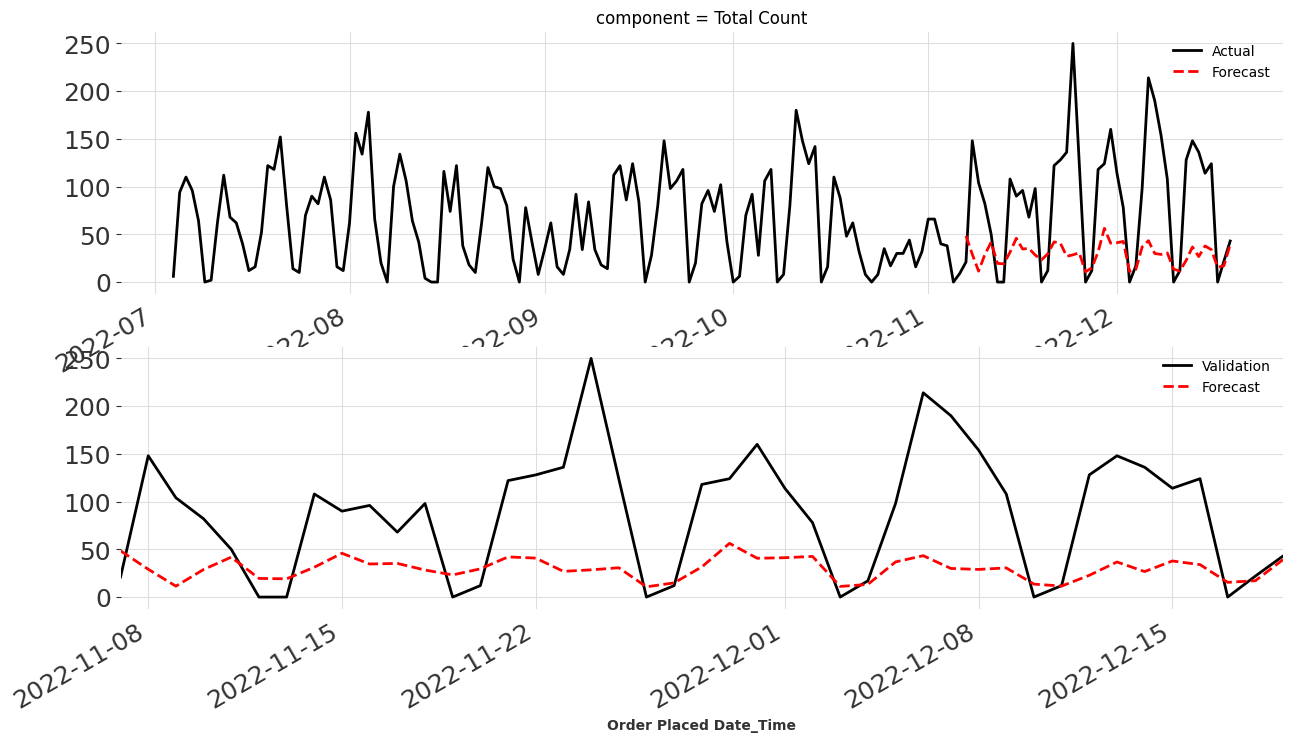

In [46]:
NB, forecast  = eval_model(NBEATSModel(input_chunk_length=28, output_chunk_length=7, n_epochs=50, random_state=0),series_scaled,train,val)

<AxesSubplot: xlabel='Order Placed Date_Time'>

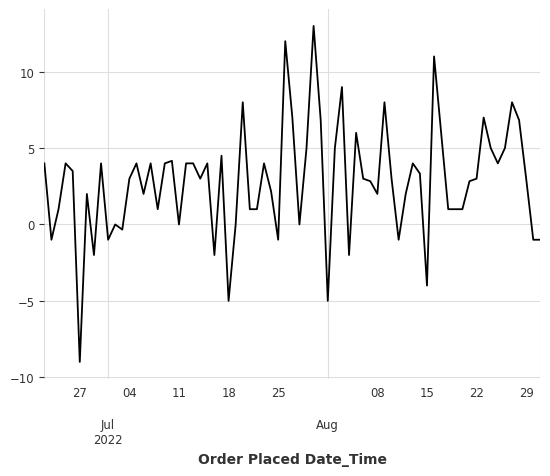

In [ ]:
f = forecast.pd_dataframe()
f = f.apply(np.floor)
v = val.pd_dataframe()
d = v['Total Count'] - f['Total Count']
d.plot()

In [ ]:
def epoch_hpt(ephs):
    model = NBEATSModel(input_chunk_length=28, output_chunk_length=7, n_epochs=ephs, random_state=0)
    model.fit(train, verbose = False)
    forecast = model.predict(len(val))
    mase_err = mase(val, forecast, train)
    return ephs, mase_err

In [ ]:
ephs_lst = []
mase_err_lst = []
for i in range(10,20):
    print(i)
    ephs, mape_err = epoch_hpt(i)
    ephs_lst.append(ephs)
    mase_err_lst.append(mape_err)

GPU available: False, used: False


10


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=10` reached.


11


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=11` reached.


12


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=12` reached.


13


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=13` reached.


14


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=14` reached.
GPU available: False, used: False


15


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=15` reached.


16


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=16` reached.


17


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=17` reached.
GPU available: False, used: False


18


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=18` reached.


19


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=19` reached.


<AxesSubplot: xlabel='ephs'>

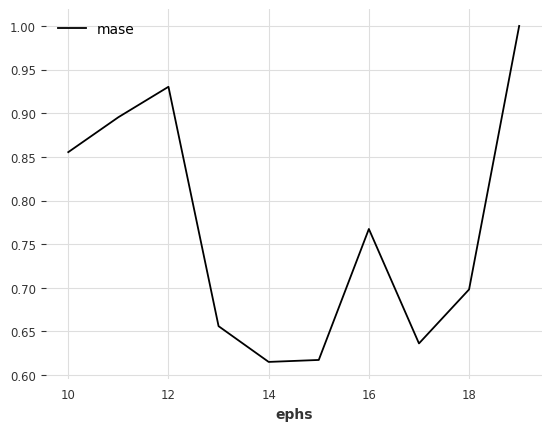

In [ ]:
hpt = pd.DataFrame.from_dict({'ephs': ephs_lst, 'mase': mase_err_lst})
hpt.plot(x = 'ephs', y = 'mase')

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0     
1  | val_metrics                       | MetricCollection                 | 0     
2  | input_embeddings                  | _MultiEmbedding                  | 0     
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
4  | encoder_vsn                       | _VariableSelectionNetwork        | 1.2 K 
5  | decoder_vsn                       | _VariableSelectionNetwork        | 528   
6  | static_context_grn                | _GatedResidualNetwork            | 1.1 K 
7  | static_context_hidden_encoder_grn | _GatedResidualNetwork            | 1.1 K 
8  | static_cont

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


Predicting: 6it [00:00, ?it/s]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


model <darts.models.forecasting.tft_model.TFTModel object at 0x000001C87F1D82E0> MASE: 0.93.
model <darts.models.forecasting.tft_model.TFTModel object at 0x000001C87F1D82E0> R2: -0.92.


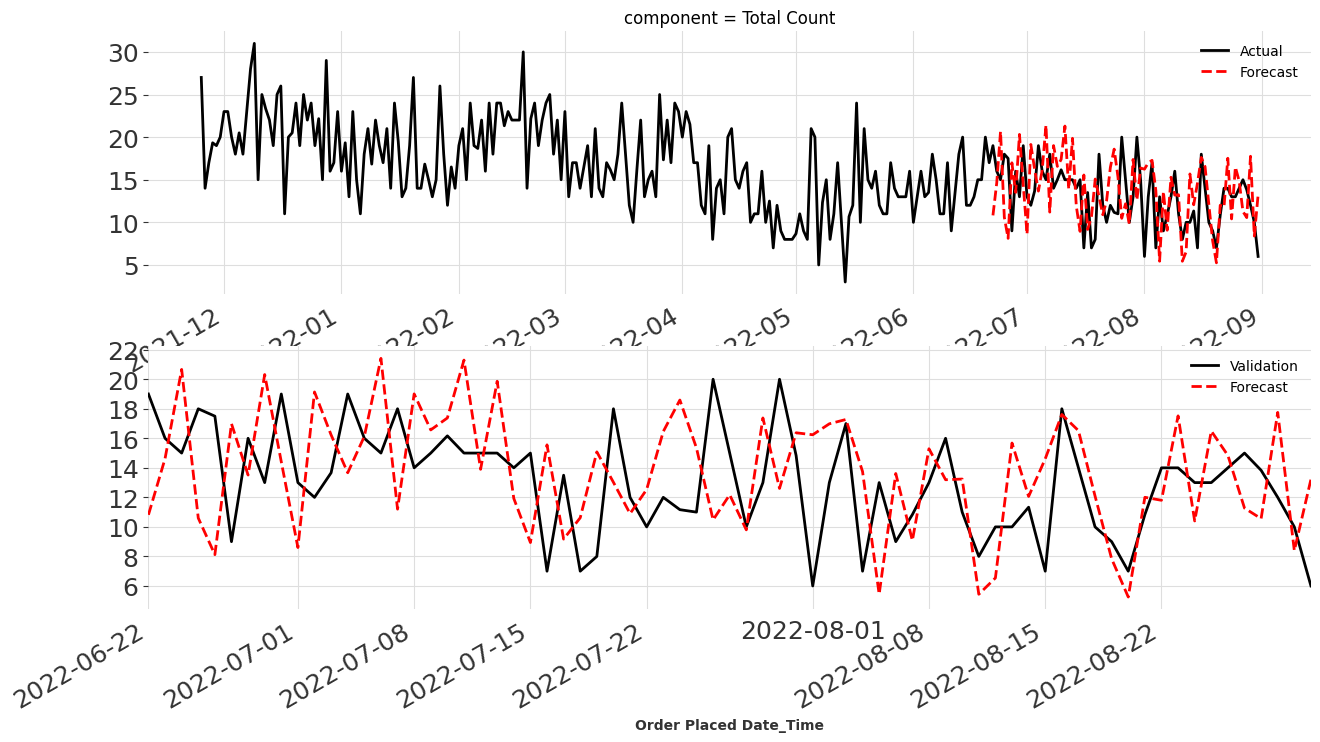

In [ ]:
TFT, forecast_TFT  = eval_model(TFTModel(input_chunk_length=28, output_chunk_length=7, n_epochs=100, random_state=0,add_relative_index = True),series_scaled,train,val)

(0.0, 5.0)

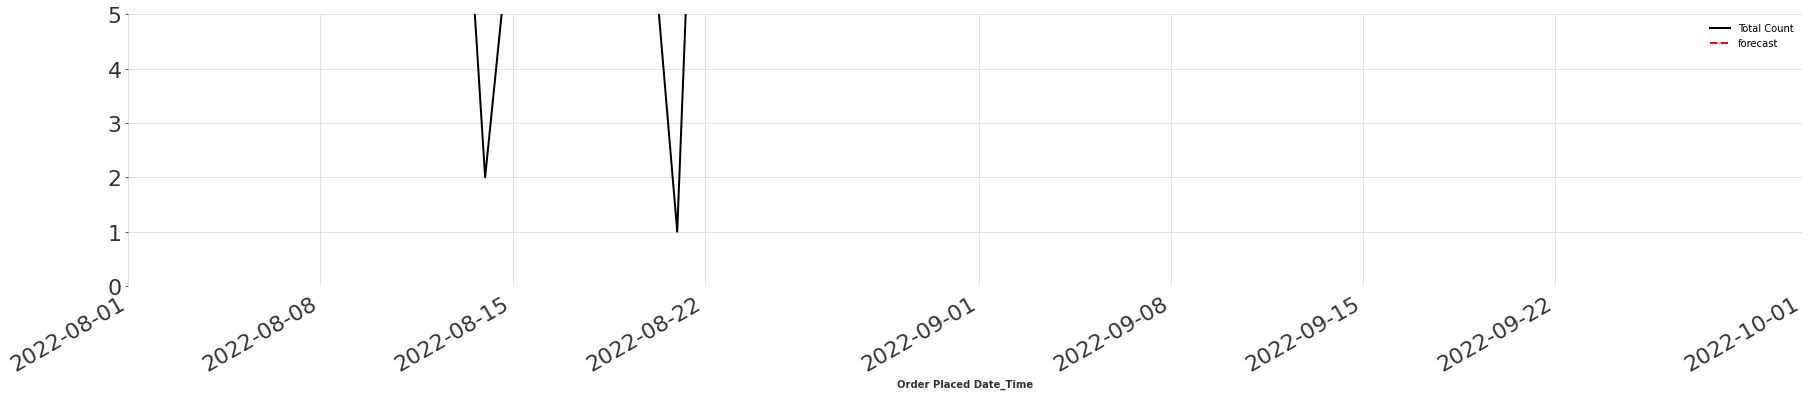

In [ ]:
prediction = model.predict(len(val))
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(30,5))
cycler = plt.cycler(linestyle=['-', '--',], color=['black', 'red'])
ax = fig.add_subplot()
ax.set_prop_cycle(cycler)
fig1 = plt.figure(1)
series.plot(ax =ax)
prediction.plot(label="forecast", low_quantile=0.05, high_quantile=0.95,ax =ax)
plt.legend()
# Set tick font size
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
	label.set_fontsize(22)
ax.set_xlim(pd.Timestamp('2022-08-01'), pd.Timestamp('2022-10-01'))
ax.set_ylim(0, 5)

In [ ]:
prediction = model.predict(len(val))

In [ ]:
prediction = prediction.pd_dataframe()


In [ ]:
prediction['Total Count'] = prediction['Total Count'].apply(np.ceil)

In [ ]:
prediction

component,Total Count
Order Placed Date_Time,
2022-06-22,13.0
2022-06-23,12.0
2022-06-24,12.0
2022-06-25,14.0
2022-06-26,13.0
...,...
2022-08-27,9.0
2022-08-28,10.0
2022-08-29,10.0


In [ ]:
prediction['Total Count'] <= 0

Order Placed Date_Time
2022-06-22    False
2022-06-23    False
2022-06-24    False
2022-06-25    False
2022-06-26    False
              ...  
2022-08-27    False
2022-08-28    False
2022-08-29    False
2022-08-30    False
2022-08-31    False
Freq: D, Name: Total Count, Length: 71, dtype: bool

In [ ]:
prediction[prediction['Total Count'] <= 0] = 0


In [ ]:
prediction = TimeSeries.from_dataframe(prediction)

In [ ]:
r = val.pd_dataframe()
r['Total Count'].min()

1.0

In [ ]:
r = val.pd_dataframe()
s = prediction.pd_dataframe()

In [ ]:
r

component,Total Count
Order Placed Date_Time,
2022-06-22,19.0
2022-06-23,16.0
2022-06-24,15.0
2022-06-25,18.0
2022-06-26,4.0
...,...
2022-08-27,15.0
2022-08-28,7.0
2022-08-29,12.0


In [ ]:
s

component,Total Count
Order Placed Date_Time,
2022-06-22,13.0
2022-06-23,12.0
2022-06-24,12.0
2022-06-25,14.0
2022-06-26,13.0
...,...
2022-08-27,9.0
2022-08-28,10.0
2022-08-29,10.0


In [ ]:
from darts.metrics import mase,ope,r2_score
mase(TimeSeries.from_dataframe(r,freq='H'),TimeSeries.from_dataframe(s,freq='H'),train)


0.5596804708850115

In [ ]:
ope(TimeSeries.from_dataframe(r,freq='H'),TimeSeries.from_dataframe(s,freq='H'))

8.19672131147541

In [ ]:
r2_score(TimeSeries.from_dataframe(r,freq='H'),TimeSeries.from_dataframe(s,freq='H'))

0.023698069046226067